<a href="https://colab.research.google.com/github/tommycwong/ensemble_TEM/blob/master/TEM_Helium_Bubbles_Predictions_and_Analysis_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting, Identifying and Analyzing Helium Bubbles in TEM Images Using Ensemble DNN

Notebook prepared by Maxim Ziatdinov and Tommy Wong

The purpose of this notebook is to use an ensemble DNN model to identify helium bubbles in TEM images and then perform graphical and statistical analysis on the results.

Mount Google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import functions from Google drive:

In [ ]:
import os
os.chdir('/content/drive/Shared drives/NESLS/TEM_Helium_Bubbles_[Proper]')

Mount GitHub repository:

In [ ]:
# For enssemble training model
!pip install -q atomai==0.3.6

In [ ]:
!git clone https://github.com/tommycwong/TEM_HeliumBubbles.git
%cd TEM_HeliumBubbles

fatal: destination path 'TEM_HeliumBubbles' already exists and is not an empty directory.
/content/drive/Shared drives/NESLS/TEM_Helium_Bubbles_[Proper]/TEM_HeliumBubbles


Import modules:

In [ ]:
# Modules for image augmentation/postprocessing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2

# Modules for DNN
import atomai as aoi
from atomai.experimental import ensembles

# Modules for blob detection
from math import sqrt
from skimage import data
from skimage.feature import blob_log
from __future__ import division
from sklearn.cluster import DBSCAN
from sklearn import metrics
import time

Load training and testing images:

In [ ]:
os.chdir('/content/drive/Shared drives/NESLS/TEM_Helium_Bubbles_[Proper]')
train_images = np.load('Data/Training data/train_images.npy') # training images
test_images = np.load('Data/Unprocessed data/test_images.npy') # testing images

##Predicting with the DNN

Start timer:

In [ ]:
start_time = time.time()

Load the model:

In [ ]:
basemodel, ensemble = ensembles.load_ensemble("/content/drive/Shared drives/NESLS/TEM_HeliumBubbles/Trained_torch/bubbles_unet_bnorm_swa_from_scratch_1_ensemble.tar")

Select an image and identify bubbles in the image:

In [ ]:
def classification(pred_img_i):
    
    # Perform classification on a single image
    (prediction, img_var), _ = ensembles.ensemble_predictor(basemodel, ensemble).run(pred_img_i, num_batches=1)
    pred_results2D = prediction[0, :, :, 0]
    pred_results2D = (pred_results2D > 0.25) * pred_results2D # Intensity threshold for detection
    
    return pred_results2D

In [ ]:
# Select an image (index):
k = 8
#pred_img2D = test_images[:, :, k] # from train or test images
pred_img2D = train_images[:, :, k]

# Perform classification:
#pred_img2D = cv2.resize(pred_img2D, (2048, 2048), cv2.INTER_AREA) # Resize for test images 25-30 only
pred_results = classification(pred_img2D)

Batch 1/1

Superimpose the prediction results on the original image:

In [ ]:
superim = np.copy(pred_img2D)
for i in range(superim.shape[0]):
    for j in range(superim.shape[1]):
        if pred_results[i, j] != 0:
            superim[i, j] = pred_results[i, j]

Display the images:

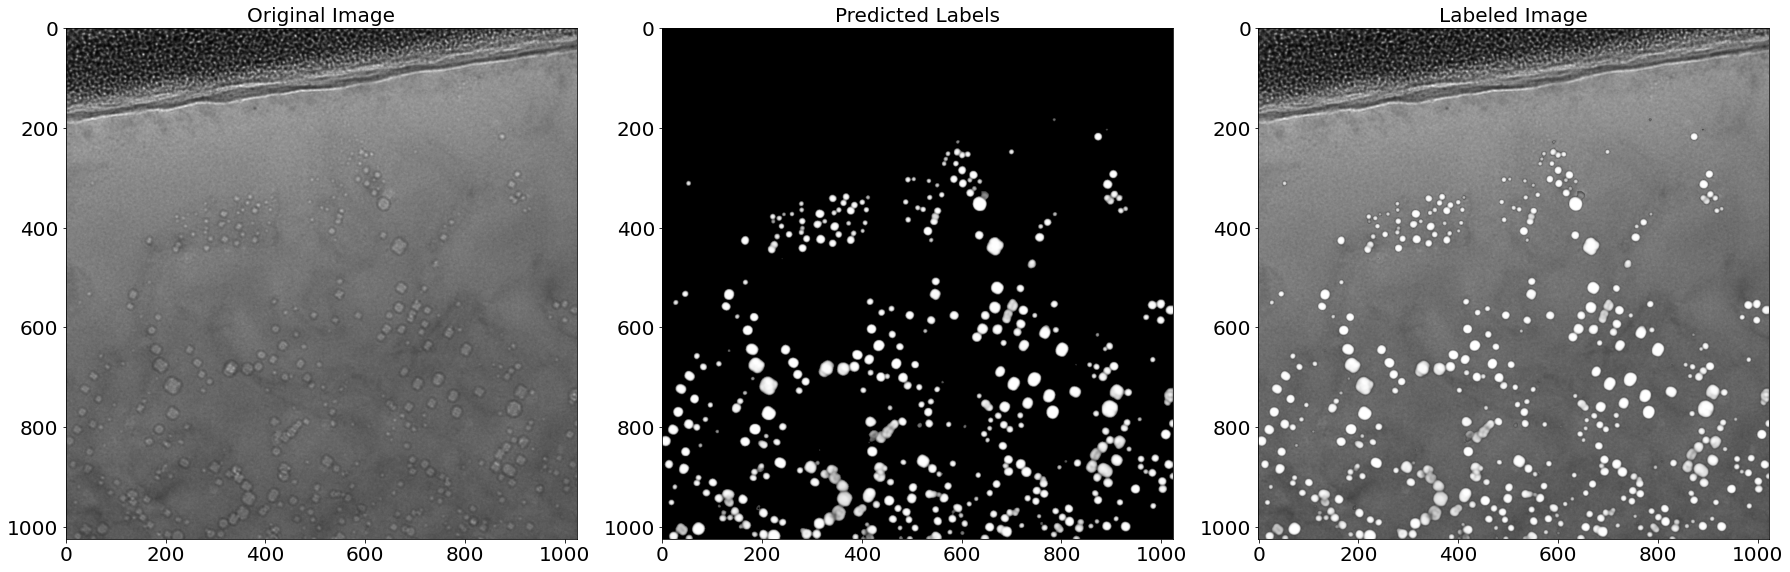

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (25, 40))
ax[0].imshow(pred_img2D, cmap='gist_gray')
ax[0].title.set_text('Original Image')
ax[0].title.set_size(20)

ax[1].imshow(pred_results, cmap='gray')
ax[1].title.set_text('Predicted Labels')
ax[1].title.set_size(20)

ax[2].imshow(superim, cmap='gist_gray')
ax[2].title.set_text('Labeled Image')
ax[2].title.set_size(20)
#fig.text(0.5, 0.69, 't=1, 2, 3; v=0; e=2500', horizontalalignment='center', size=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
fig.tight_layout()

In [ ]:
superim = np.zeros((pred_results.shape[0], pred_results.shape[1]))
for i in range(pred_results.shape[0]):
    for j in range(pred_results.shape[1]):
        superim[i, j] = pred_img2D[i, j]
        if pred_results[i, j] > 0.25:
            superim[i, j] = pred_results[i, j]

Save the images:

In [ ]:
os.chdir('/content/drive/Shared drives/NESLS/TEM_Helium_Bubbles_[Proper]/Prediction results')
#fig.savefig('{}-Prediction.png'.format(model), orientation='landscape', bbox_inches='tight')

##Counting Bubbles

Define a function to identify individual bubbles:

In [ ]:
def BubbleFinder(pred2D, min_sigma=1, max_sigma=3*3, threshold=0.25, overlap=1, param1=0.1, param2=15, minRadius=1, maxRadius=15, eps=5, min_samples=2):
    
    # LoG
    pred2D_i = pred2D * 255
    blobs_log = blob_log(pred2D_i, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold * 255, overlap=overlap)
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    
    # Hough transform
    cimg = cv2.GaussianBlur(pred2D, (5, 5), 0, 0)

    for i in range(cimg.shape[0]):
        for j in range(cimg.shape[1]):
            if cimg[i, j] < threshold:
                cimg[i, j] = 0
                
    cimg = np.uint8(cimg * 255)
    circles = cv2.HoughCircles(cimg, cv2.HOUGH_GRADIENT, 1 ,1 ,param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)[0]
    
    # Concatenate coordinates and radii
    blobs_log_xyr = np.transpose(np.array([blobs_log[:, 1], blobs_log[:, 0], blobs_log[:, 2]]))
    coords_r = np.vstack((blobs_log_xyr, circles))
    coords = coords_r[:, 0:2]

    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, algorithm = 'ball_tree').fit(coords)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = np.transpose(db.labels_)

    coords_r = np.column_stack((coords_r, labels))

    coords_s = np.empty((0, 4))

    for i in range(0, labels.max()+1):
        r = np.where(coords_r[:, 3] == i)
        x = np.mean(coords_r[r, :], axis=1, dtype=np.float64)
        coords_s = np.append(coords_s, x, axis=0)

    s = np.where(coords_r[:, 3] == -1)
    coords_a = np.vstack((coords_s, coords_r[s, :][0]))
    
    return coords_a

Use LoG and Hough transform to identify individual bubbles and visualize them:

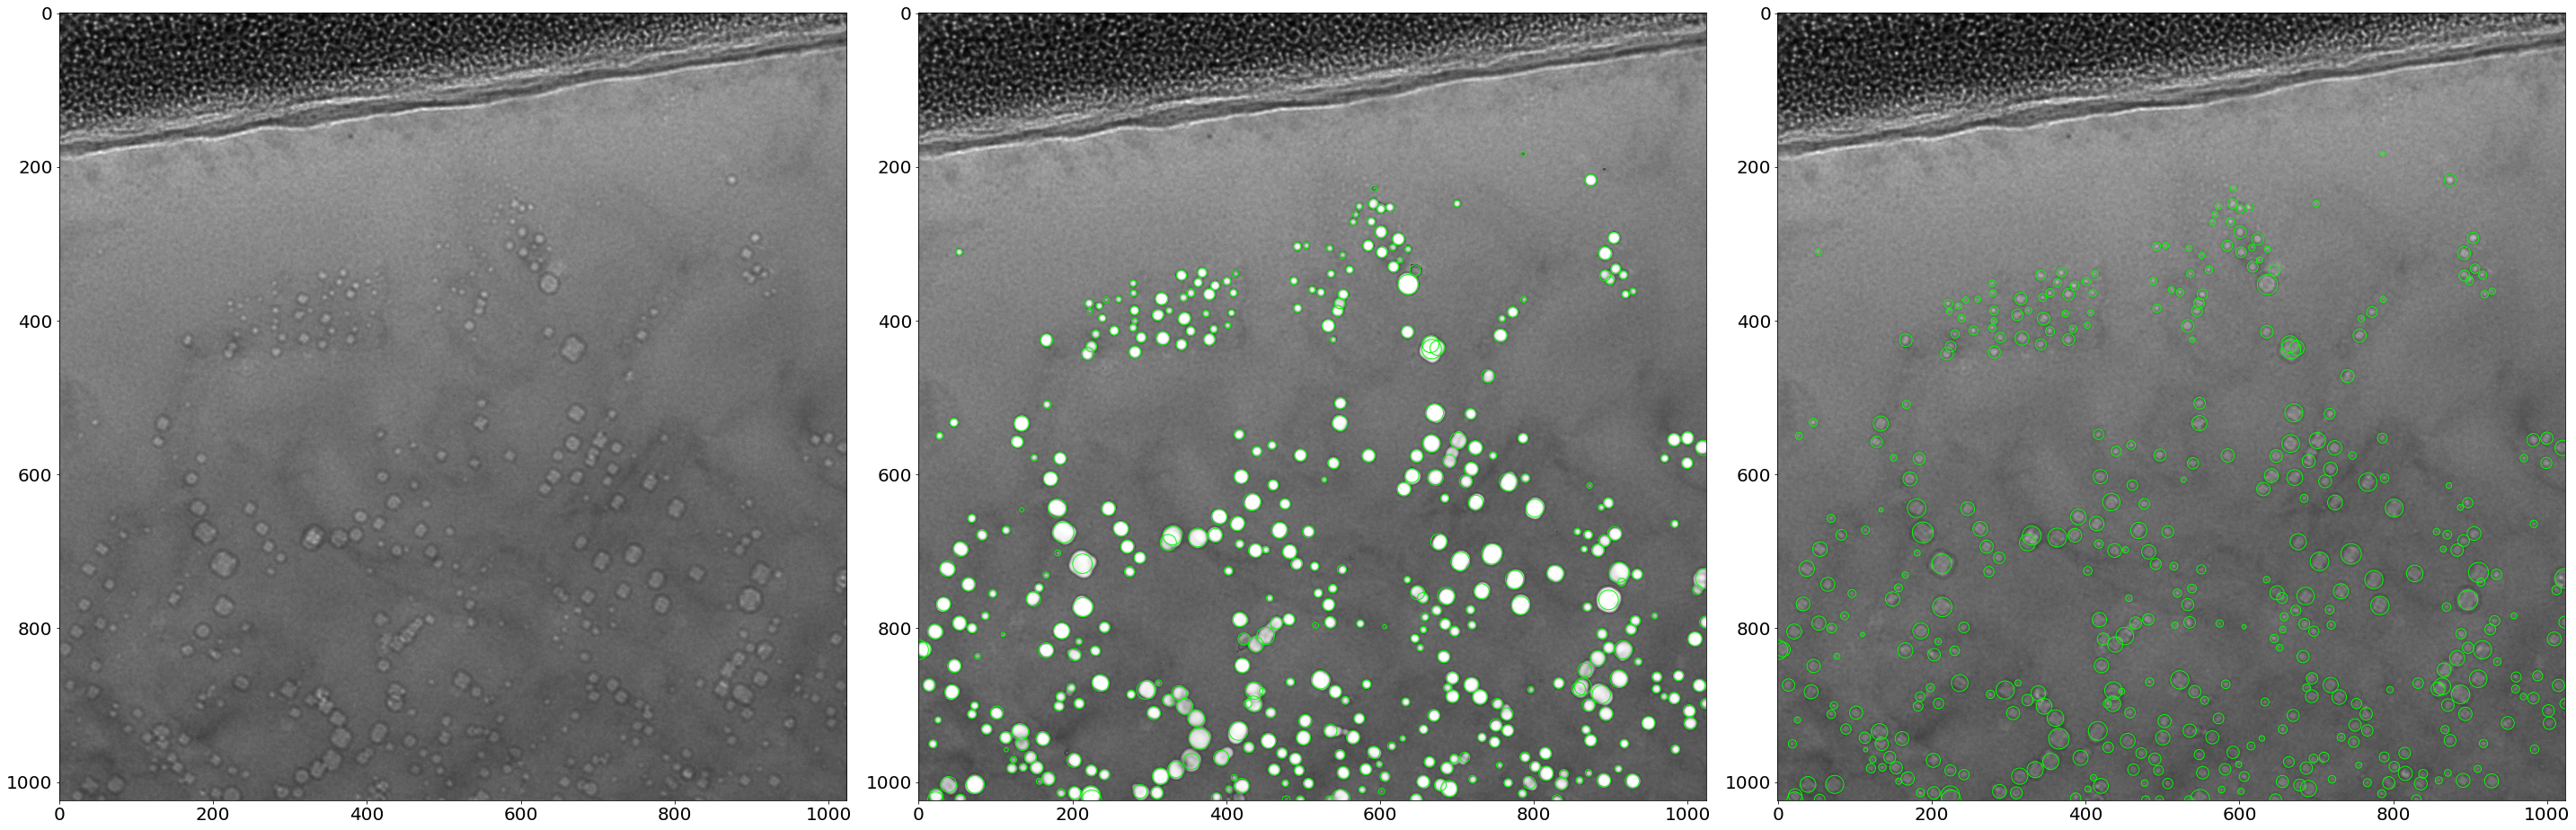

In [ ]:
coords = BubbleFinder(pred_results, min_sigma=1, max_sigma=3*3, threshold=0.25, overlap=1, param1=0.1, param2=15, minRadius=1, maxRadius=15, eps=5, min_samples=2)

fig, axes = plt.subplots(1, 3, figsize=(40, 40))
ax = axes.ravel()
      
ax[0].imshow(pred_img2D, cmap='gist_gray')

ax[1].imshow(superim, cmap='gist_gray')
for blob in coords:
    x, y, r, i = blob
    c = plt.Circle((x, y), r, color='lime', linewidth=1, fill=False)
    ax[1].add_patch(c)

ax[2].imshow(pred_img2D, cmap='gist_gray')
for blob in coords:
    x, y, r, i = blob
    c = plt.Circle((x, y), r, color='lime', linewidth=1, fill=False)
    ax[2].add_patch(c)

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)    
plt.tight_layout()

#os.chdir('/content/drive/Shared drives/NESLS/TEM_HeliumBubbles/Images for Outline')
#plt.savefig('Predictions_1.png')

An example of overlapping bubbles identified:

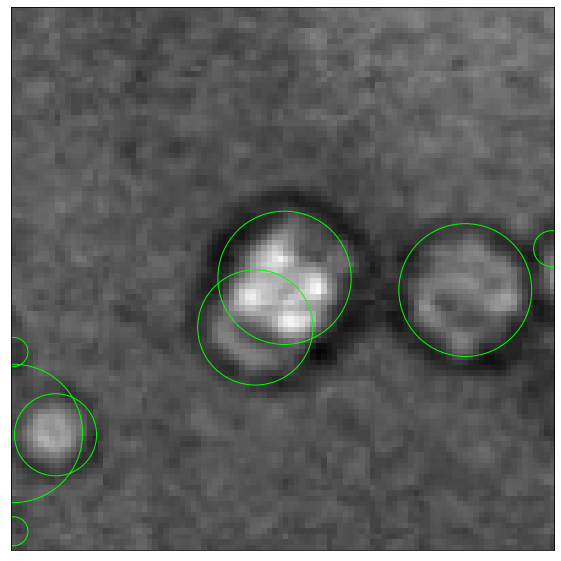

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.imshow(pred_img2D[630:730, 280:380], cmap='gist_gray')
for blob in BubbleFinder(pred_results[630:730, 280:380]):
    x, y, r, i = blob
    c = plt.Circle((x, y), r, color='lime', linewidth=1, fill=False)
    ax.add_patch(c)

End timer (representing the process of labeling the bubbles):

In [ ]:
print('time elapsed: ', time.time()-start_time, ' s')

time elapsed:  12.143372058868408  s


Calculate the statistics of the bubbles:

Text(0.5, 1.0, 'Total no. of bubbles: 411')

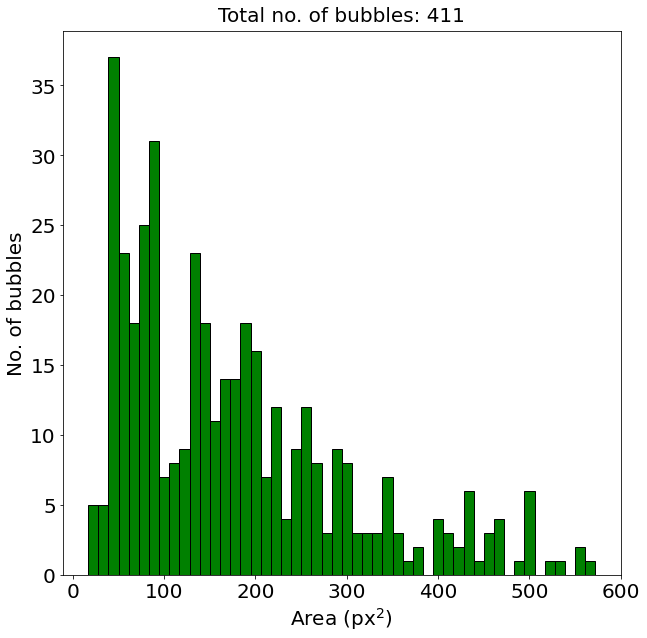

In [ ]:
area = coords[:, 2] ** 2 * np.pi # area of a circle
fig = plt.figure(figsize=(10, 10))
plt.hist(area, bins=50, align='left', rwidth=1, color='green', edgecolor='black', linewidth=1)
plt.xlabel('Area (px$^2$)', fontdict={'fontsize':20})
plt.ylabel('No. of bubbles', fontdict={'fontsize':20})
no_bubbles = len(coords[:, 2])
plt.title('Total no. of bubbles: ' + str(no_bubbles), fontdict={'verticalalignment':'bottom', 'fontsize':20})
#os.chdir('/content/drive/Shared drives/NESLS/TEM_HeliumBubbles/Images for Outline')
#plt.savefig('numberofbubbles_1.png', bbox_inches='tight', transparent=True)